In [2]:
%matplotlib inline

import numpy as np

import matplotlib.image as mpimg

import matplotlib.pyplot as plt

import matplotlib.cm as cm

import png

import scipy.ndimage as ndimage

from scipy.misc import imsave, imshow

from scipy.ndimage import filters

import pyopencl as cl

In [3]:
# inpainting images
img = ndimage.imread('./shibascarf.jpg')
height, width, channels = img.shape
print height, width, channels

270 340 3


In [4]:
def show(img):
    plt.axis("off")
    plt.imshow(img, cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

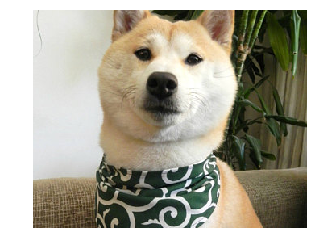

In [5]:
show(img)

<pyopencl.Context at 0x7fdd5fe1a790 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
Copying input image from host...
Copied input from host
Creating output buffer
Created output buffer
CPU times: user 86.2 ms, sys: 19.1 ms, total: 105 ms
Wall time: 132 ms


/Users/jake/venvs/cl-tutorial/lib/python2.7/site-packages/pyopencl/cffi_cl.py:1502: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


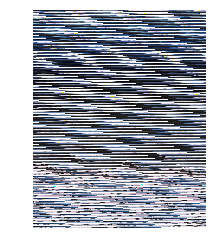

In [6]:
%%time
# OpenCL stuff starts here
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags


prg = cl.Program(ctx, """
// Use plain old integer coords | don't do anything fancy for out of bounds access | don't do interpolation
const sampler_t sampler = CLK_NORMALIZED_COORDS_FALSE | CLK_ADDRESS_NONE | CLK_FILTER_NEAREST;

__kernel void swap_r_and_b(
    __read_only image2d_t src,
    __write_only image2d_t dest
) {
    // get position of current pixel
    int2 coord = (int2)(get_global_id(0), get_global_id(1));
    
    // get value of current pixel
    float4 color = read_imagef(src, sampler, coord);
    
    // swap r and b values
    const float r = color.r;
    //color.r = color.b;
    //color.b = r;
    
    // write new value to output image2d_t
    write_imagef(dest, coord, color);
}
""").build()

# Copy data from host to device
print "Copying input image from host..."
in_g = cl.image_from_array(ctx, img.astype(np.float32), 3)
print "Copied input from host"

# Create an image2d output buffer
print "Creating output buffer"
fmt = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.FLOAT)
out_g = cl.Image(ctx, mf.WRITE_ONLY, fmt, shape=(width, height))
print "Created output buffer"
# Grab references to the kernels. When we do attribute access on prg, it creates an instance of each kernel.
# Because of this, we need to do `foo = prg.foo; foo.bar` and not just `prg.foo.bar`.
swap_r_and_b = prg.swap_r_and_b

swap_r_and_b(queue, img.shape, None, in_g, out_g)
  
result_np = np.empty((height, wi, 4), np.float32)
cl.enqueue_copy(queue, result_np, out_g, origin=(0, 0), region=(width, height))

# Show results
show(result_np)

In [39]:
imshow(result_np)

RuntimeError: Could not execute image viewer.